Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import spacy
import pickle
import random

Load spacy, disable 'ner' and 'parser', keep tagger only. require GPU.

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes('ner', 'parser')
#spacy.require_gpu()

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f8c12f5cbb0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f8c12f5cc90>)]

In [ ]:
print(nlp.pipe_names)

['tagger']


Mount Google Drive

In [ ]:
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preprocessing**

Read data and save as a list where each element is a tuple of lists which are: (keywords, keywords_pos, template, sentence)

In [ ]:
# fine grained pos tags
#pos_tags = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 
#           'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
# coarse grained pos tags
keyword_tags = ['NOUN', 'VERB', 'ADJ', 'ADV']
def read_data(filepath):
  data = []

  with open(filepath) as f:
    # the sentences are the labels
    labels = [sentence[:-1] for sentence in f]
    for doc in nlp.pipe(labels, batch_size=2000, n_process=10): 
      # templates are the POS tags of the sentence
      template = list(map(lambda word : word.tag_, doc))
      # sentence as list of words (sentence is the gold standard reference)
      label = [str(token).lower() for token in doc]
      # extract (and lemmatize) keywords
      keywords = extract_keywords(doc)
      # get keywords pos tags (individually)
      keywords_pos = list(map(lambda word: extract_pos(nlp(word)), keywords))
      data.append((keywords, keywords_pos, template, label))
  return data

In [ ]:
# Find words in a sentence whose POS tag is a noun, verb, adjective or adverb. Lemmatize and store as keyword.
def extract_keywords(doc):
  kw = []
  for word in doc:
    if word.pos_ in keyword_tags:
      kw.append(nlp(str(word).lower())[0].lemma_)
  return kw

In [ ]:
# Extract pos of a single word (Individually, no context)
def extract_pos(word):
  return word[0].pos_

In [ ]:
# Read data (Quotes dataset)
train_pre = read_data('drive/MyDrive/TGP/train.txt')
test_pre = read_data('drive/MyDrive/TGP/test.txt')
valid_pre = read_data('drive/MyDrive/TGP/valid.txt')

In [ ]:
# Save data file on Google Drive
with open('drive/MyDrive/TGP/prepared_train_fg.txt', 'wb') as f1:
  pickle.dump(train_pre, f1)
with open('drive/MyDrive/TGP/prepared_test_fg.txt', 'wb') as f2:
  pickle.dump(test_pre, f2)
with open('drive/MyDrive/TGP/prepared_valid_fg.txt', 'wb') as f3:
  pickle.dump(valid_pre, f3)

In [ ]:
# Define function for sorting that returns the length of the sentence as key
def sortKey(e):
  return len(e[3])

In [ ]:
# Sort data according to the length of a sentence
data.sort(key=sortKey)

In [ ]:
# Add start and end of sentence tokens - "<sos>", "<eos>"
for i, (kw, kw_pos, template, sentence) in enumerate(data):
  template = ["<sos>"] + template + ["<eos>"]
  # For sentence we only use the <sos> token for generation
  sentence = ["<sos>"] + sentence
  data[i] = (kw, kw_pos, template, sentence)

# **Data Loading**

In [ ]:
currentFile = open('prepared_train_fg.txt', mode='rb')
training_data = pickle.load(currentFile)

In [ ]:
currentFile = open('prepared_valid_fg.txt', mode='rb')
validation_data = pickle.load(currentFile)

In [ ]:
currentFile = open('prepared_test_fg.txt', mode='rb')
test_data = pickle.load(currentFile)

In [ ]:
len(training_data)

251096

In [ ]:
len(validation_data)

37468

In [ ]:
len(test_data)

31757

In [ ]:
# For GPU VRAM testing
training_data.reverse()
validation_data.reverse()



---



The following Vocab class is served as a dictionary that maps words and tags into Ids. The __unk__ token is used for words that are not part of the training data, while __pad__ token is used as padding value (0). <sos> and <eos> are start and end of sentence tokens respectively.

In [ ]:
class Vocab:
    def __init__(self):
      self.word2id = {"__pad__": 0, "__unk__": 1, "<sos>": 2}
      self.id2word = {0: "__pad__", 1: "__unk__", 2: "<sos>"}
      self.n_words = 2
        
      self.tag2id = {"__pad__": 0, "<sos>": 1, "<eos>": 2, "ADJ":3, "ADP":4, "ADV":5, "AUX":6, "CONJ":7, 
                     "CCONJ":8, "DET":9, "INTJ":10, "NOUN":11, "NUM":12, "PART":13, "PRON":14, "PROPN":15, 
                     "PUNCT":16, "SCONJ":17, "SYM":18, "VERB":19, "X":20, "SPACE":21, ".": 22, ",": 23, 
                     "-LRB-": 24, "-RRB-": 25, "``": 26, '""': 27, "''": 28, ":": 29, "$": 30, "#": 31,
                     "AFX": 32, "CC": 33, "CD": 34, "DT": 35, "EX": 36, "FW": 37, "HYPH": 38, "IN": 39, 
                     "JJ": 40, "JJR": 41, "JJS": 42, "LS": 43, "MD": 44, "NIL": 45, "NN": 46, "NNP": 47, 
                     "NNPS": 48, "NNS": 49, "PDT": 50, "POS": 51, "PRP": 52, "PRP$": 53, "RB": 54, "RBR": 55, 
                     "RBS": 56, "RP": 57, "TO": 58, "UH": 59, "VB": 60, "VBD": 61, "VBG": 62, "VBN": 63, 
                     "VBP": 64, "VBZ": 65, "WDT": 66, "WP": 67, "WP$": 68, "WRB": 69, "SP": 70, "ADD": 71, 
                     "NFP": 72, "GW": 73, "XX": 74, "BES": 75, "HVS": 76, "_SP": 77}
      self.id2tag = {v:k for (k, v) in self.tag2id.items()}
        
    def index_words(self, words):
      word_indexes = [self.index_word(w) for w in words]
      return word_indexes

    def index_tags(self, tags):
      tag_indexes = [self.tag2id[t] for t in tags]
      return tag_indexes
    
    def index_word(self, w):
        if w not in self.word2id:
          self.n_words += 1
          self.word2id[w] = self.n_words
          self.id2word[self.n_words] = w
        return self.word2id[w]

In [ ]:
# Function for creating a new vocabulary from the words in the training data
def create_vocabulary(data):
    vocab = Vocab()
    for (keywords, _, _, sentence) in data:
      for token in sentence:
        vocab.index_word(token)
      for keyword in keywords:
        vocab.index_word(keyword)
      
    return vocab

In [ ]:
vocab = create_vocabulary(training_data)

In [ ]:
vocab.n_words

83610

In [ ]:
# For test and validation data: convert unknown words to "__unk__" tag
def convert_unk(data):
  for i, (kw, kw_pos, template, sentence) in enumerate(data):
    new_kw = []
    new_sentence = []
    for keyword in kw:
      keyword = keyword if keyword in vocab.word2id.keys() else "__unk__"
      new_kw.append(keyword)
    for word in sentence:
      word = word if word in vocab.word2id.keys() else "__unk__"
      new_sentence.append(word)
    
    data[i] = (new_kw, kw_pos, template, new_sentence)
  
  return data

In [ ]:
validation_data = convert_unk(validation_data)
test_data = convert_unk(test_data)

In [ ]:
# Use the vocabulary to convert the data from strings to integers
def convert_data(data, vocab):
  int_data = []
  for (keywords, keywords_pos, template, sentence) in data:
    int_kw = [vocab.word2id[keyword] for keyword in keywords]
    int_kw_pos = [vocab.tag2id[keyword_pos] for keyword_pos in keywords_pos]
    int_template = [vocab.tag2id[pos] for pos in template]
    int_sentence = [vocab.word2id[word] for word in sentence]
    int_data.append((int_kw, int_kw_pos, int_template, int_sentence))
  
  return int_data

In [ ]:
training_data = convert_data(training_data, vocab)
validation_data = convert_data(validation_data, vocab)
test_data = convert_data(test_data, vocab)

In [ ]:
# Create batches and pad relevant input data
def create_batches(data, batch_size=64):
  # The list to store all instances and corresponding labels
  data_batches = []
  # Keyword batch to store in data_batches
  kw_batch = []
  # Keyword pos batch to store in data_batches
  kw_pos_batch = []
  # Template batch to store in data_batches 
  template_batch = []
  # Store lengths of each instance in template batch for packing
  template_len = []
  # Sentence batch to store in data_batches
  sentence_batch = []
  
  for i, (keywords, keywords_pos, template, sentence) in enumerate(data):
    kw_batch.append(torch.LongTensor(keywords))
    kw_pos_batch.append(torch.LongTensor(keywords_pos))
    template_batch.append(torch.LongTensor(template))
    template_len.append(len(template))
    sentence_batch.append(torch.LongTensor(sentence))

    if (i + 1) % batch_size == 0:
      # Pad batchs of size batch_size
      kw_batch = torch.nn.utils.rnn.pad_sequence(kw_batch, batch_first=True)
      kw_pos_batch = torch.nn.utils.rnn.pad_sequence(kw_pos_batch, batch_first=True)
      template_batch = torch.nn.utils.rnn.pad_sequence(template_batch, batch_first=True)
      sentence_batch = torch.nn.utils.rnn.pad_sequence(sentence_batch, batch_first=True)

      data_batches.append((kw_batch, kw_pos_batch, (template_batch, template_len), sentence_batch))
      
      # Reinitialize the batches
      kw_batch = []
      kw_pos_batch = []
      template_batch = []
      template_len = []
      sentence_batch = []
      label_batch = []
    
  return data_batches

In [ ]:
training_data = create_batches(training_data)
validation_data = create_batches(validation_data)
test_data = create_batches(test_data)

# **Model Architecture**

In [ ]:
class Generator(nn.Module):
  def __init__(self, w_embed_dim=500, tag_embed_dim=len(vocab.tag2id)):
    super(Generator, self).__init__()
    # Embedding layer for words (shared between keywords and sentences)
    self.word_embed = nn.Embedding(num_embeddings=vocab.n_words, embedding_dim=w_embed_dim, padding_idx=0)
    # Embedding layer for pos tags (shared between keyword tags and templates)
    self.tag_embed = nn.Embedding(num_embeddings=tag_embed_dim, embedding_dim=tag_embed_dim, padding_idx=0)
    # Dropout layer for keyword embedding
    self.dropout = nn.Dropout(p=0.5)
    
    # Keyword encoder
    self.kw_encoder = FFNN(w_embed_dim)
    # Template encoder
    self.template_encoder = TemplateEncoder(tag_embed_dim, n_layers=4)
    # Max Tag Overlap (template and keyword tag matching)
    self.mto = MTO(1)
    # Attention layer
    self.attn = Attention()
    # Decoder
    self.decoder = Decoder(h_size=w_embed_dim, n_layers=4)


  def forward(self, kw, kw_pos, template_pack, sentence, tr_ratio=0.5):    
    # Keyword encoder
    kw_embed = self.dropout(self.word_embed(kw))
    encoded_kw = self.kw_encoder(kw_embed)

    # Template encoder
    template, template_len = template_pack
    template_embed = self.tag_embed(template)
    packed_template = torch.nn.utils.rnn.pack_padded_sequence(template_embed, template_len, 
                                                              batch_first=True, enforce_sorted=False)
    outputs, last_hidden = self.template_encoder(packed_template)
    # Embed keyword pos tags
    kw_pos_embed = self.tag_embed(kw_pos)

    # Get lambda weights from Max Tag Overlap
    lambdas, lambdas_c = self.mto(template_embed, kw_pos_embed)

    # Embed sentence
    sentence_embed = self.word_embed(sentence)

    # First input is the <sos> token
    input = sentence_embed[:, 0, :].unsqueeze(1)

    # Initialize hidden layer for decoder
    hidden = torch.zeros(4, sentence.size(0), 500).cuda() 

    # Initialize mask to ignore padded values in attention mechanism 
    mask = torch.any((kw_embed != 0), dim=2).cuda()

    # List to store predictions
    preds = []
    for t in range(1, sentence_embed.size(1)):
      # Use attention to calculate context vector
      a = self.attn(outputs[:,t,:], last_hidden, encoded_kw, mask)
      context = torch.bmm(a.unsqueeze(1), encoded_kw)
      # Multiply this time step's context by its weight lambda
      context *= lambdas[:,t,:].unsqueeze(1)
      # Multiply this time step's template encoding by its weight lambda c (1 minus lambda)
      htt =  outputs[:,t,:].unsqueeze(1) * lambdas_c[:,t,:].unsqueeze(1)
      # mt is tanh of the concatenation of context and current time step's encoded template
      mt = torch.tanh(torch.cat((context, htt), dim=2))
      # Input to the decoder is the concatenation of mt and the embedding of a word from current time step t
      decoder_input = torch.cat((input, mt), dim=2)
      # Decode
      pred, hidden, last_hidden = self.decoder(decoder_input, hidden)
      # Store the prediction
      preds.append(pred)
      # Calculate next input, unless it's the last iteration
      if t < sentence_embed.size(1) - 1:
        # Teacher force mechanism (If true, feed next layer with ground truth)
        teacher_force = torch.rand(1).item() < tr_ratio
        # The last prediction with the highest probability
        last_pred = torch.argmax(pred, dim = 1).cuda()
        # If teacher_force is true, use ground truth, else the last prediction
        input = sentence_embed[:, t, :].unsqueeze(1) if teacher_force else self.word_embed(last_pred.unsqueeze(1))
    
    return torch.stack(preds, dim=1)

In [ ]:
# Keyword encoder - Fully connected neural network
class FFNN(nn.Module):
  def __init__(self, h_dim):
    super(FFNN, self).__init__()
    self.fc1 = nn.Linear(h_dim, h_dim)
    self.lrelu1 = nn.LeakyReLU(0.01)
    self.fc2 = nn.Linear(h_dim, h_dim)
    self.lrelu2 = nn.LeakyReLU(0.01)
    self.fc3 = nn.Linear(h_dim, h_dim)
  
  
  def forward(self, x):
    x = self.lrelu1(self.fc1(x))
    x = self.lrelu2(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return x

In [ ]:
# Template encoder - stack of bidirectional GRU's
class TemplateEncoder(nn.Module):
  def __init__(self, input_dim, h_size=100, n_layers=4):
    super(TemplateEncoder, self).__init__()
    self.gru = nn.GRU(input_size=input_dim, hidden_size=h_size, num_layers=n_layers, batch_first=True, 
                      dropout=0.5, bidirectional=True)
    self.fc = nn.Linear(2*h_size, 2*h_size)
  
  def forward(self, x):
    outputs, hidden = self.gru(x)
    outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
    hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1)))

    return outputs, hidden

In [ ]:
# Template and keyword tag matching (Max Tag Overlap)
class MTO(nn.Module):
  def __init__(self, input_size):
    super(MTO, self).__init__()
    self.fc = nn.Linear(input_size, input_size)

  def forward(self, template_embed, kw_pos_embed):
    # Calculate s - the max cosine similarity between each template tag and keyword tag
    s_batch = []
    for template_tags, keyword_tags in zip(template_embed, kw_pos_embed):
      s = []
      for t_pos in template_tags:
        s.append(torch.max(F.cosine_similarity(keyword_tags, t_pos.unsqueeze(0))).item())
      s_batch.append(torch.tensor(s))

    s_batch = torch.stack(s_batch).unsqueeze(2)
    s_batch = s_batch.cuda()

    # Lambdas are weights which are equal to s going into a sigmoid on top of a linear layer 
    lambdas = torch.sigmoid(self.fc(s_batch))
    # Lambda_c is 1-lambda for each weight lambda in lambdas
    lambdas_c = torch.add(torch.multiply(lambdas, -1), 1)

    return lambdas, lambdas_c

In [ ]:
# Attention layer (additive attention)
class Attention(nn.Module):
  def __init__(self):
    super(Attention, self).__init__()
    self.w = torch.nn.Linear(900, 500)
    self.v = nn.Linear(500, 1, bias=False)

  def forward(self, enc_template_o, hidden, encoded_kw, mask):
    # Unsqueeze for repeat
    hidden = hidden.unsqueeze(1)
    enc_template_o = enc_template_o.unsqueeze(1)
    # Repeat for stacking
    hidden = hidden.repeat(1, encoded_kw.size(1), 1)
    enc_template_o = enc_template_o.repeat(1, encoded_kw.size(1), 1)
    # Conatenate last hidden layer, the encoded keywords and the encoded template
    energy = torch.tanh(self.w(torch.cat((hidden, encoded_kw, enc_template_o), dim=2)))
    # Calculate score
    attention = self.v(energy).squeeze(2)
    # Mask
    attention = attention.masked_fill(mask == 0, -1e10)

    return F.softmax(attention, dim=1)

In [ ]:
# Decoder
class Decoder(nn.Module):
  def __init__(self, h_size=500, n_layers=4):
    super(Decoder, self).__init__()
    self.gru = nn.GRU(input_size=1200, hidden_size=500, num_layers=n_layers, batch_first=True, 
                      dropout=0.5, bidirectional=False)
    self.fc = nn.Linear(1000, 200)
    self.fc_out = nn.Linear(1700, vocab.n_words)

  def forward(self, gru_input, hidden_input):
    outputs, hidden = self.gru(gru_input, hidden_input)
    # Last hidden layers for attention
    last_hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1)))
    prediction = self.fc_out(torch.cat((outputs.squeeze(1), gru_input.squeeze(1)), dim=1))
    return prediction, hidden, last_hidden

In [ ]:
random.shuffle(training_data)

# **Training**

In [ ]:
# Initialize the model
model = Generator().cuda()

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Step learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

# Initialize epoch loss list for checkpoint system
epoch_loss = []

# Initialize epoch to 0 for checkpoint system
epoch = 0

In [ ]:
# Load model checkpoint
checkpoint = torch.load('model_checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch_loss = checkpoint['epoch_loss']
epoch = checkpoint['epoch']

In [ ]:
print(epoch)

40


Evaluation function for validation

In [ ]:
def evaluate(model, valid_set, criterion):
  # Change model to evaluation mode
  model.eval()
  
  epoch_loss = 0

  with torch.no_grad():
    for i, (kw, kw_pos, (template, template_len), sentence) in enumerate(valid_set, 1):
      kw = kw.cuda()
      kw_pos = kw_pos.cuda()
      template = template.cuda()
      sentence = sentence.cuda()

      output = model(kw, kw_pos, (template, template_len), sentence, 0)
      loss = criterion(output.reshape(-1, output.shape[-1]), sentence[:, 1:].reshape(-1))

      epoch_loss += loss.item()
  
  return epoch_loss / len(valid_set)

Training loop

In [ ]:
# Training loop
def train_loop(model, n_epochs, train_set, valid_set, tr_ratio):
  for e in range(1, n_epochs + 1):
    # Activate model training mode
    model.train()
    # Reset epoch loss
    t_epoch_loss = 0

    for i, (kw, kw_pos, (template, template_len), sentence) in enumerate(train_set, 1):
      kw = kw.cuda()
      kw_pos = kw_pos.cuda()
      template = template.cuda()
      sentence = sentence.cuda()

      optimizer.zero_grad()
      output = model(kw, kw_pos, (template, template_len), sentence, tr_ratio)
      loss = criterion(output.reshape(-1, output.shape[-1]), sentence[:, 1:].reshape(-1))
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
      optimizer.step()
      t_epoch_loss += loss.item()

    # Calculate training and validation loss
    v_epoch_loss = evaluate(model, valid_set, criterion)
    t_epoch_loss /= len(train_set)
    # Print training and validation epoch loss
    print(f"Epoch {e+epoch} train loss: {t_epoch_loss}")
    print(f"Epoch {e+epoch} validation loss: {v_epoch_loss}")
    # Save epoch loss
    epoch_loss.append((t_epoch_loss, v_epoch_loss))
    # Learning rate scheduler step
    scheduler.step(v_epoch_loss)
    # Save model every epoch
    torch.save({
            'epoch': e+epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch_loss': epoch_loss
            }, "model_checkpoint")
    # shuffle data
    random.shuffle(train_set)

In [ ]:
train_loop(model, 40, training_data, validation_data, 0.5)

# **Evaluation**

In [ ]:
# Plot train_loss and test_loss as functions of epoch
def plot_loss(train_loss, val_loss, setup_num):
  plt.plot(list(range(1,len(train_loss)+1)), train_loss, 'b', label='train set loss')
  plt.plot(list(range(1,len(val_loss)+1)), val_loss, 'r', label='validation set loss')
  plt.legend(loc="upper right")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training loss and validation loss as function of epoch, setup {setup_num}')
  plt.show()

In [ ]:
# Function for extracting training and validation loss from text file
def extract_loss(path):
   train_loss = []
   val_loss = []
   with open(path) as f:
      loss_list = list(f)
      for line in loss_list:
         line = line.split()
         train_loss.append(float(line[0]))
         val_loss.append(float(line[1]))
   return train_loss, val_loss

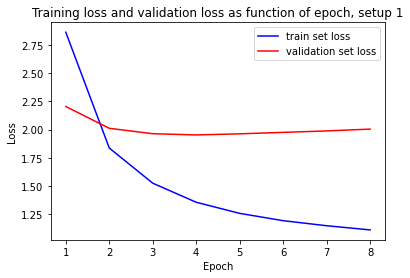

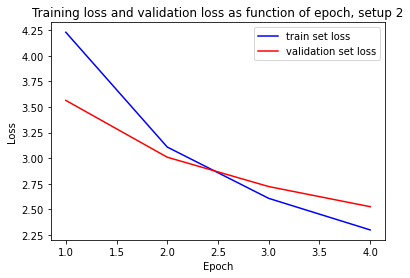

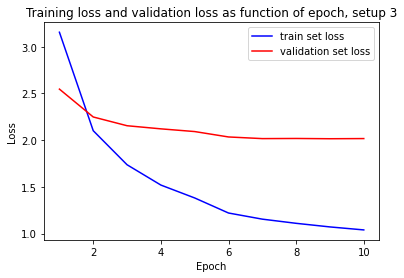

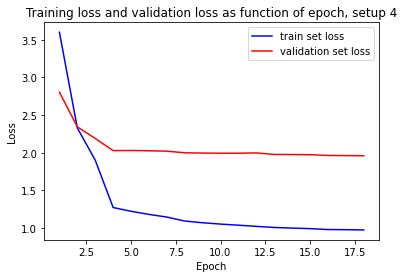

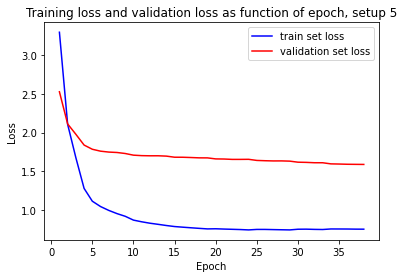

In [ ]:
for i in range(1, 6):
   train_loss, val_loss = extract_loss(f"epoch_loss_{i}.txt")
   plot_loss(train_loss, val_loss, i)

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# Function for generating text using the model
def gen_text(input):
  model.eval()
  kw, kw_pos, (template, template_len), sentence = input
  kw = kw.cuda()
  kw_pos = kw_pos.cuda()
  template = template.cuda()
  sentence = sentence.cuda()

  output = model(kw, kw_pos, (template, template_len), sentence, 0)
  predictions = torch.argmax(output, dim = 2)
  predictions = predictions.tolist()
  predictions = [[vocab.id2word[word] for word in sentence] for sentence in predictions]
  return predictions

In [ ]:
from torchtext.data.metrics import bleu_score
def bleu(data):
   bleu_score = []

   for batch in data:
      batch_bleu = []
      predictions = gen_text(batch)
      labels = [[vocab.id2word[word] for word in sentence] for sentence in batch[3].tolist()]
      labels = [label[1:] for label in labels]
      labels_len = [label.index('__pad__') if '__pad__' in label else len(label) for label in labels]
      for i, (prediction, label) in enumerate(zip(predictions, labels)):
         batch_bleu.append(sentence_bleu([label[:labels_len[i]]], prediction[:labels_len[i]]))
      bleu_score.append(sum(batch_bleu) / len(batch_bleu))      
      
   bleu_score = sum(bleu_score) / len(data)
   return bleu_score

In [ ]:
# batch 385 is bugged for some reason and batch 1 contains sentences too short for bleu evaluation
bleu_score = bleu(test_data[1:384] + test_data[386:])

In [ ]:
print(bleu_score)

0.3470001697081127
